#### trOCR & detectron pipeline demo

In [68]:
# Importing libraries
import os 
import glob 
import time
import pandas as pd
from PIL import Image
import json
import random
import cv2
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from datasets import load_metric

from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from detectron2.engine import default_setup
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel

#### Loading up database

In [69]:
def load_list_from_file(file_name):
    my_list = []
    with open(file_name, 'r') as file:
        for line in file:
            my_list.append(json.loads(line))
    return my_list

file_name = 'bounding-box.txt'
df = load_list_from_file(file_name)
new_classese = pd.read_csv('new_classes.csv')

In [70]:
# Function to split data in test and train
def split_data(lst, split):
    n = len(lst)
    n_20_percent = int(n * 0.05)
    n_80_percent = n - n_20_percent
    test = random.sample(lst, n_20_percent)
    train = [item for item in lst if item not in test]
    if split == 'train':
        return train
    
    if split == 'test':
        return test

# Function to register dataset
def register_dataset(name, dirname):
    if name not in DatasetCatalog.list():
        DatasetCatalog.register(name, lambda: split_data(df, 'train'))
        
    MetadataCatalog.get(name).set(
        thing_classes=list(new_classese['classes']), split='train', dirname= dirname
    )

In [71]:
# Loading datasets
register_dataset('new_docs_dataset_train', dirname = 'datasets')

#### Setting up configs

In [72]:
# Setting up cfg for Predictions
def setup_cfg(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.DATASETS.TRAIN = ("new_docs_dataset_train",)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

# Setting up predictors
parser = default_argument_parser()
args = parser.parse_args("--config-file tuned-detectron/config.yaml MODEL.WEIGHTS tuned-detectron/model_final.pth".split())
cfg = setup_cfg(args)

predictor = DefaultPredictor(cfg)

[04/16 04:02:45 detectron2]: Rank of current process: 0. World size: 1
[04/16 04:02:45 detectron2]: Environment info:
-------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     win32
Python                           3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
numpy                            1.23.5
detectron2                       0.6 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\detectron2
Compiler                         MSVC 193532217
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu117 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-p

#### Importing initial image

0.4362058639526367
data/parte_amistoso_6_24_13.jpg


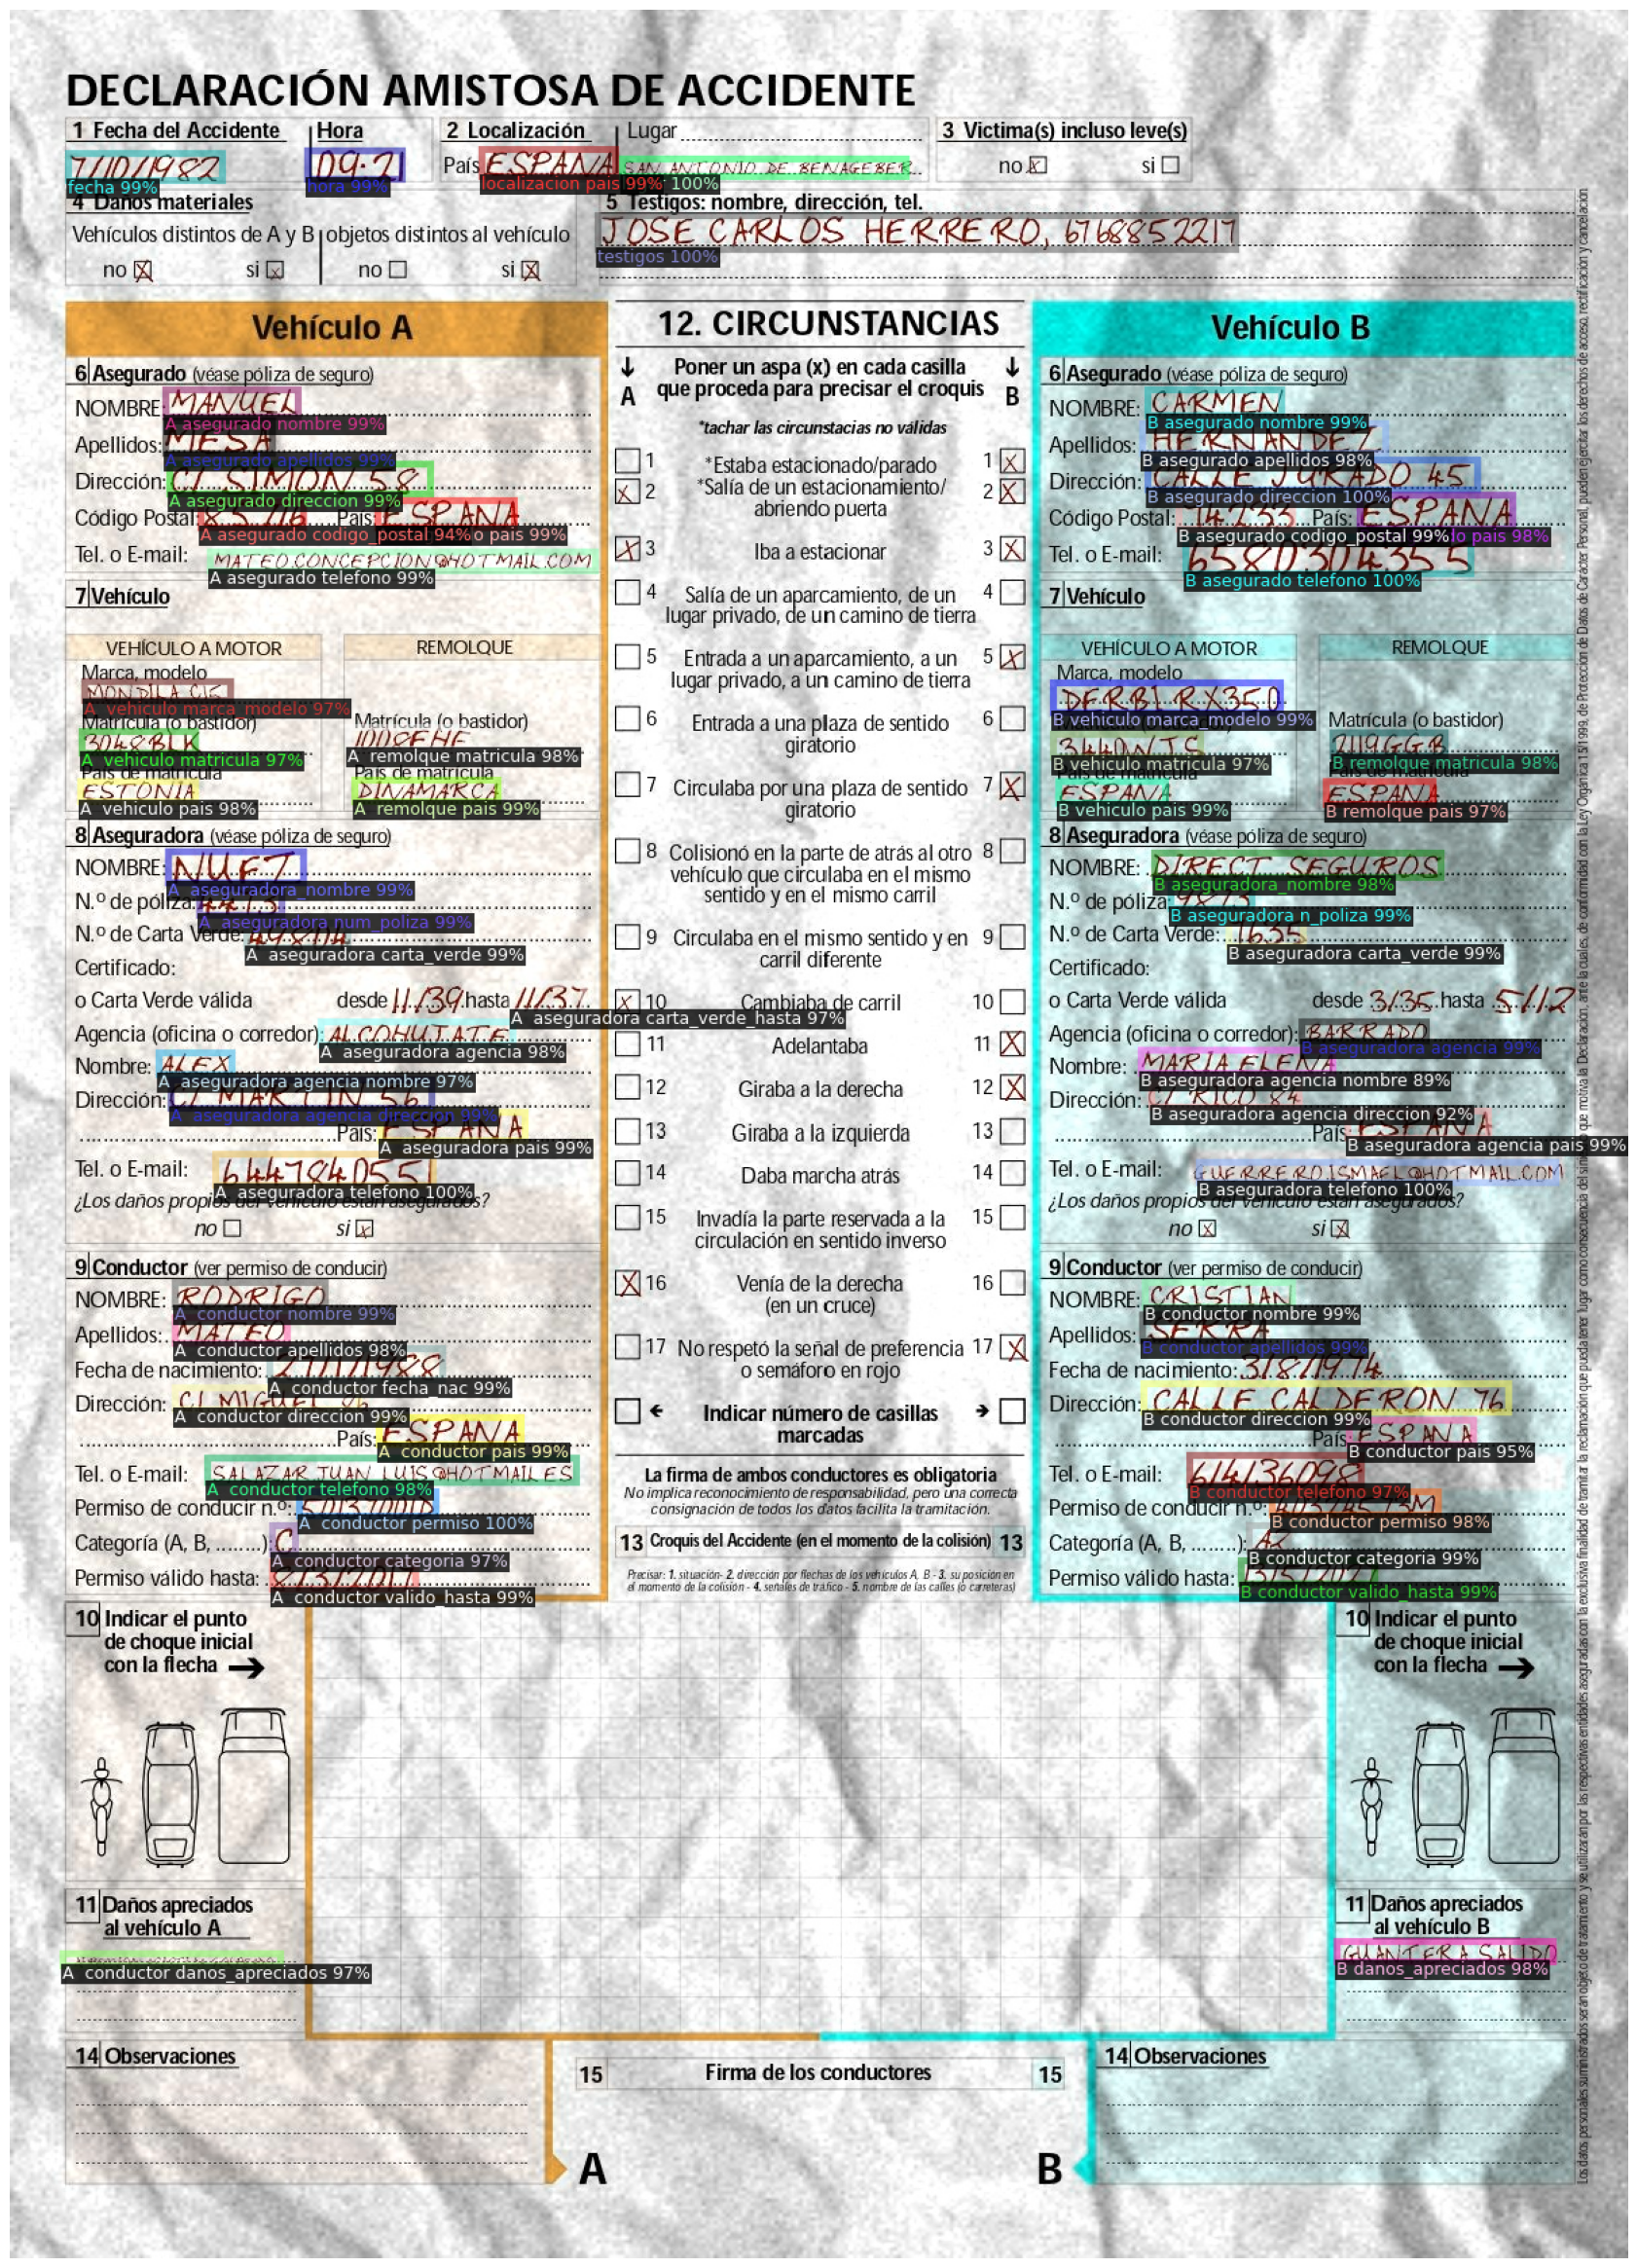

In [81]:
import os

# Create a directory to save the bounding box images
if not os.path.exists('bounding_box_images'):
    os.makedirs('bounding_box_images')
else:
    # Remove any existing files in the directory
    for file in os.listdir('bounding_box_images'):
        os.remove(os.path.join('bounding_box_images', file))

files = []
for dict in split_data(df, 'test'):
    files.append(dict['file_name'])

# Set sample size as wanted
sample_size = 1
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("new_docs_dataset_train").thing_classes = list(new_classese['classes'])
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)

    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("new_docs_dataset_train"), scale=1)
    instances = outputs["instances"].to("cpu")
    v = v.draw_instance_predictions(instances)
    print(file)
    figure(num=None, figsize=(30, 30), dpi=100, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
        
    # Save each bounding box as a .jpg file with its name being equal to the predicted class
    for i in range(len(instances)):
        class_name = MetadataCatalog.get("new_docs_dataset_train").thing_classes[instances.pred_classes[i]]
        bbox = instances.pred_boxes.tensor[i].cpu().numpy().astype(int)  # convert bounding box coordinates to integers
        box_image = im[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        cv2.imwrite(f'bounding_box_images/{class_name}.jpg', box_image)



In [82]:
# Importing models
cer_metric = load_metric("cer")
model = VisionEncoderDecoderModel.from_pretrained("tuned-trocr")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [83]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


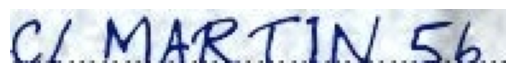

Campo:  A  aseguradora agencia direccion
C/ MARTIN 56


C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


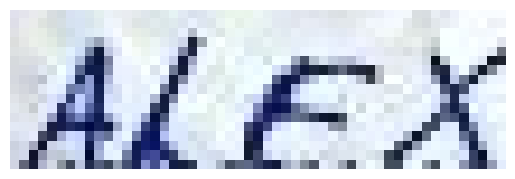

Campo:  A  aseguradora agencia nombre
ALEX


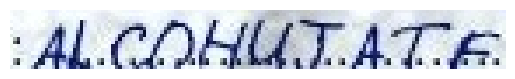

Campo:  A  aseguradora agencia
ALCOHUJATE


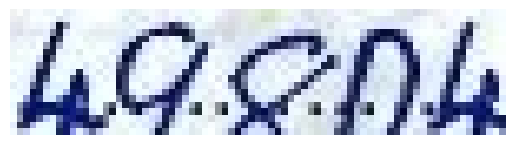

Campo:  A  aseguradora carta_verde
49804


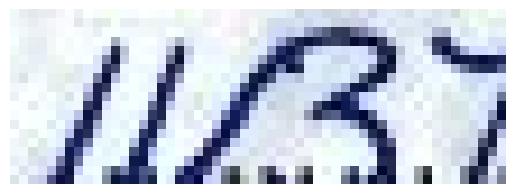

Campo:  A  aseguradora carta_verde_hasta
11/37


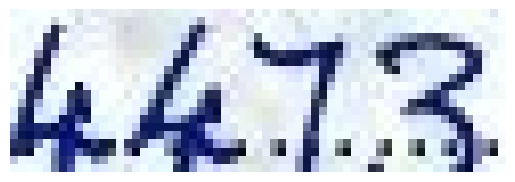

Campo:  A  aseguradora num_poliza
4473


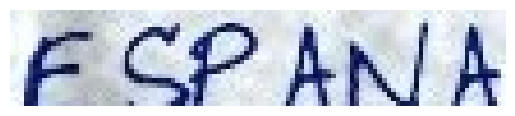

Campo:  A  aseguradora pais
ESPANA


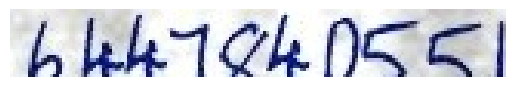

Campo:  A  aseguradora telefono
6447840551


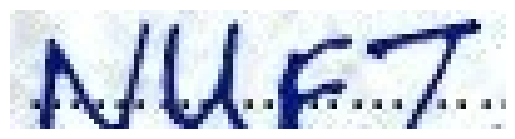

Campo:  A  aseguradora_nombre
NUEZ


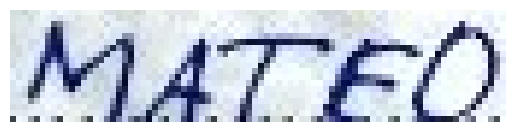

Campo:  A  conductor apellidos
MATEO


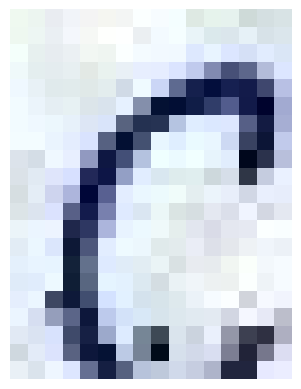

Campo:  A  conductor categoria
C


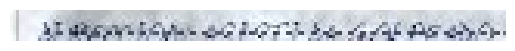

Campo:  A  conductor danos_apreciados
LIMPA DELANTERA GOLPEADO


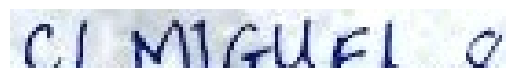

Campo:  A  conductor direccion
C/ MOGUEL O


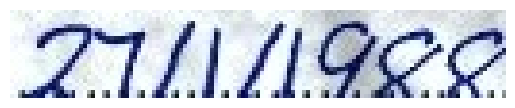

Campo:  A  conductor fecha_nac
27/1/1988


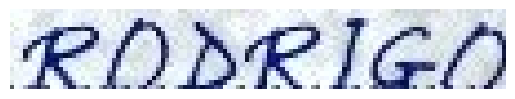

Campo:  A  conductor nombre
RODRIGO


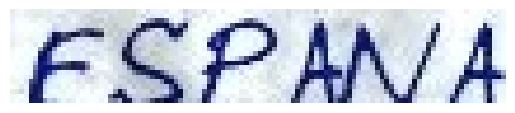

Campo:  A  conductor pais
ESPANA


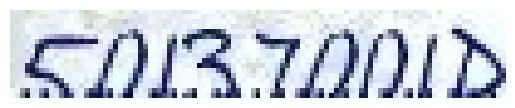

Campo:  A  conductor permiso
50137001D


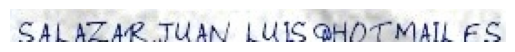

Campo:  A  conductor telefono
SALAZAR.JUAN LUIS@HOTMAIL.ES


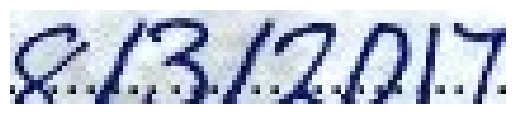

Campo:  A  conductor valido_hasta
8/3/2017


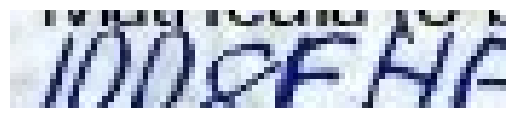

Campo:  A  remolque matricula
1008EHF


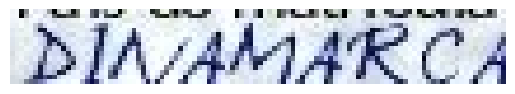

Campo:  A  remolque pais
DINAMARCA


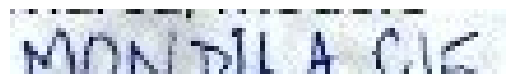

Campo:  A  vehiculo marca_modelo
MONDILA C15


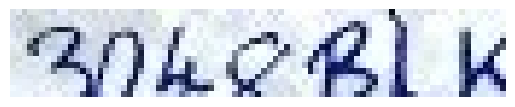

Campo:  A  vehiculo matricula
3048BLK


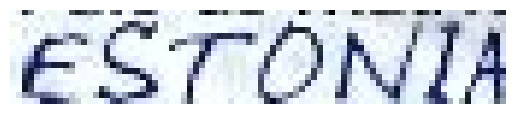

Campo:  A  vehiculo pais
ESTONIA


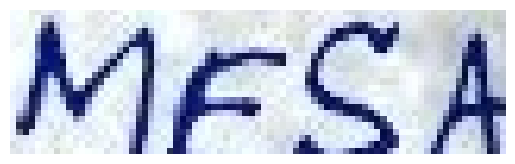

Campo:  A asegurado apellidos
MESA


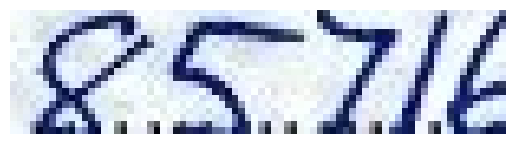

Campo:  A asegurado codigo_postal
85716


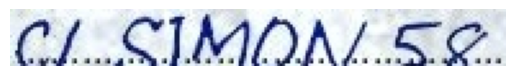

Campo:  A asegurado direccion
C/ SIMON 58


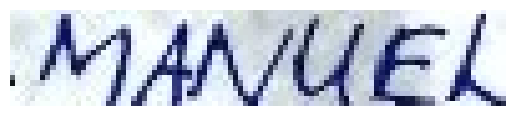

Campo:  A asegurado nombre
MANUEL


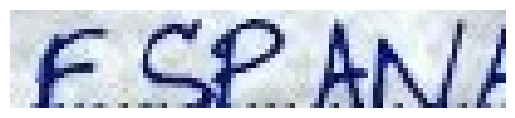

Campo:  A asegurado pais
ESPANA


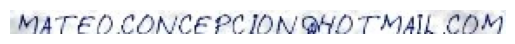

Campo:  A asegurado telefono
MATEO.CONCEPCION@HOTMAIL.COM


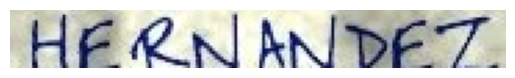

Campo:  B asegurado apellidos
HERNANDEZ


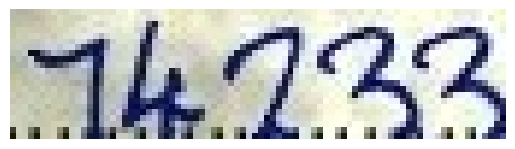

Campo:  B asegurado codigo_postal
74233


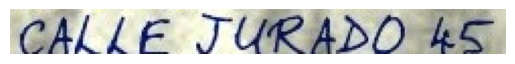

Campo:  B asegurado direccion
CALLE JURADO 45


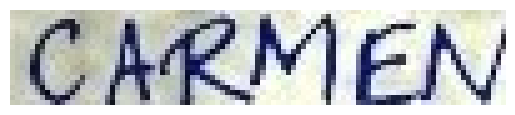

Campo:  B asegurado nombre
CARMEN


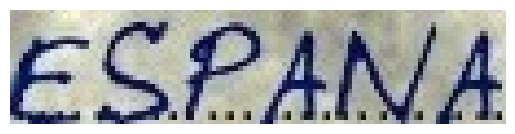

Campo:  B asegurado pais
ESPANA


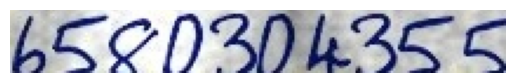

Campo:  B asegurado telefono
6580304355


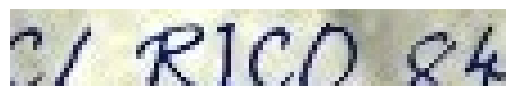

Campo:  B aseguradora agencia direccion
C/ RICO 84


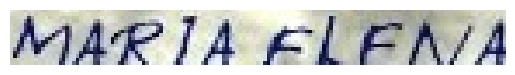

Campo:  B aseguradora agencia nombre
MARIA ELENA


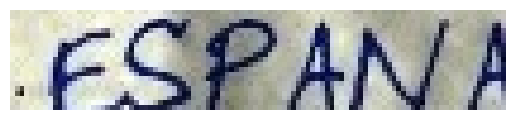

Campo:  B aseguradora agencia pais
ESPANA


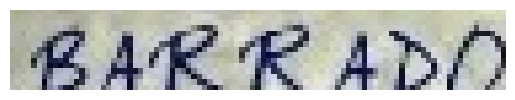

Campo:  B aseguradora agencia
BARRADO


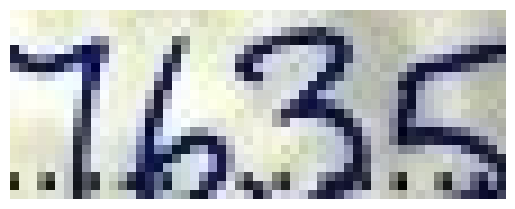

Campo:  B aseguradora carta_verde
7635


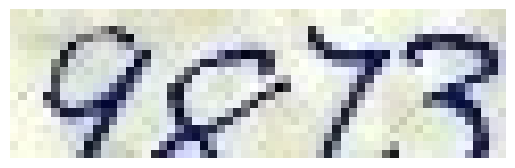

Campo:  B aseguradora n_poliza
9873


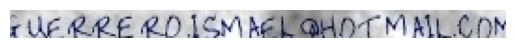

Campo:  B aseguradora telefono
TUERRERO.ISMAIL@HOTMAIL.COM


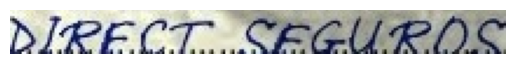

Campo:  B aseguradora_nombre
DIRECT SEGUROS


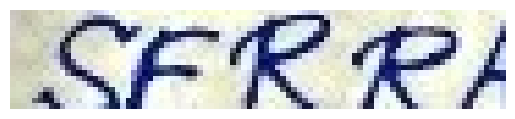

Campo:  B conductor apellidos
SERRA


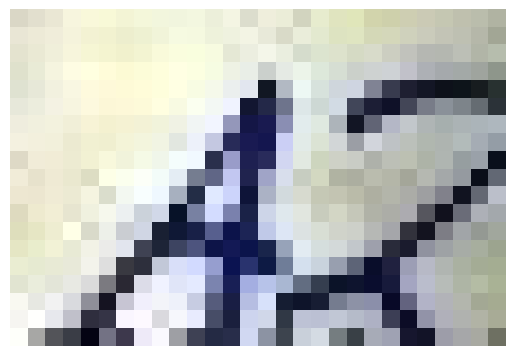

Campo:  B conductor categoria
A2


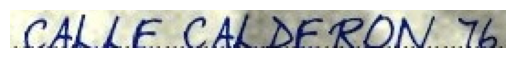

Campo:  B conductor direccion
CALLE CALDERON 76


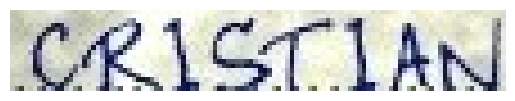

Campo:  B conductor nombre
CRISTIAN


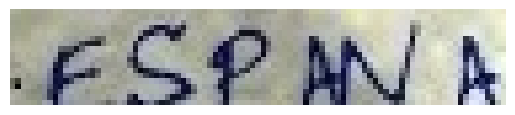

Campo:  B conductor pais
ESPANA


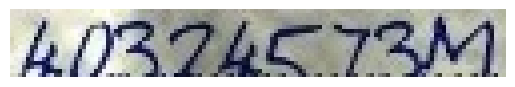

Campo:  B conductor permiso
40324573M


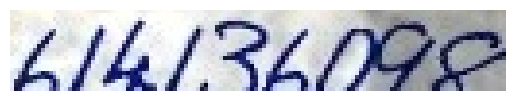

Campo:  B conductor telefono
614136098


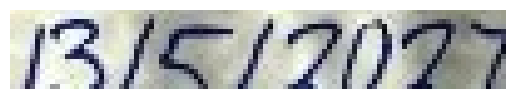

Campo:  B conductor valido_hasta
13/5/2027


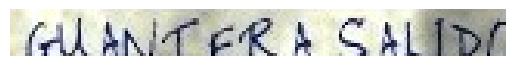

Campo:  B danos_apreciados
GUANTERA SALIDO


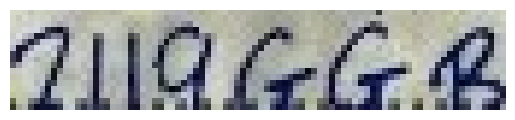

Campo:  B remolque matricula
2119GGB


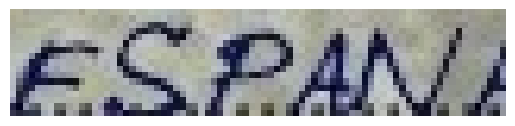

Campo:  B remolque pais
ESPANA


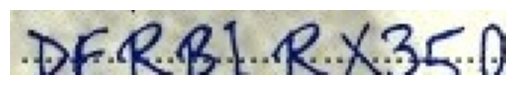

Campo:  B vehiculo marca_modelo
DERBI RX350


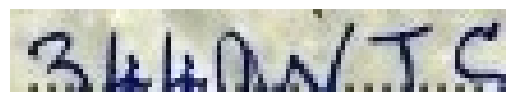

Campo:  B vehiculo matricula
3440WJS


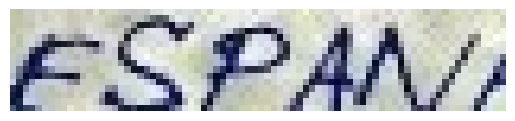

Campo:  B vehiculo pais
ESPANA


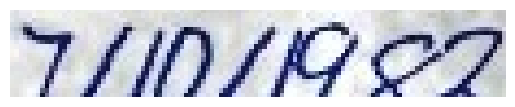

Campo:  fecha
7/10/1982


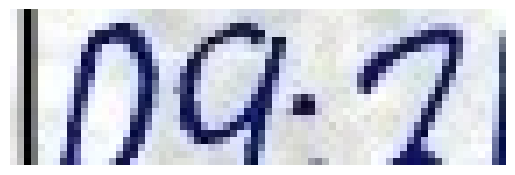

Campo:  hora
109:21


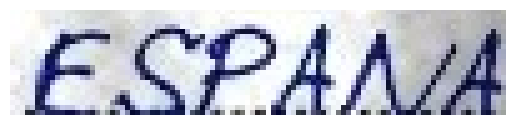

Campo:  localizacion pais
ESPANA


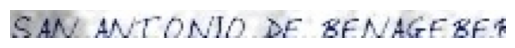

Campo:  lugar
SAN ANTONIO DE BENAGEBER


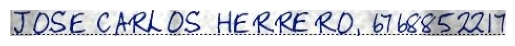

Campo:  testigos
JOSE CARLOS HERRERO, 6768852217


In [84]:
files = []
classes = pd.read_csv('new_classes.csv')
def retrieve_sample(path):
    image = Image.open('bounding_box_images/' + path).convert("RGB")
    # calling the processor is equivalent to calling the feature extractor
    pixel_values = processor(image, return_tensors="pt").pixel_values
    return image, pixel_values

def add_value_to_specific(df, column_to_check, value_to_check, column_to_add, value_to_add):
    df.loc[df[column_to_check] == value_to_check, column_to_add] = value_to_add
    return df

def generate_many():
    boxes = pd.DataFrame()
    boxes['classes'] = classes['classes'] 

    for file in os.listdir('bounding_box_images'):
        image, pixel_values = retrieve_sample(file)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        add_value_to_specific(boxes, 'classes', file.split('.jpg')[0], 'texto', generated_text)
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        print('Campo: ', file.split('.jpg')[0])
        print(generated_text)
    return boxes

final_csv = generate_many()

#### Final CSV

In [85]:
final_csv

classes                            texto
0             A  aseguradora agencia                       ALCOHUJATE
1   A  aseguradora agencia direccion                     C/ MARTIN 56
2      A  aseguradora agencia nombre                             ALEX
3         A  aseguradora carta_verde                            49804
4   A  aseguradora carta_verde_desde                              NaN
..                               ...                              ...
62                             fecha                        7/10/1982
63                              hora                           109:21
64                 localizacion pais                           ESPANA
65                             lugar         SAN ANTONIO DE BENAGEBER
66                          testigos  JOSE CARLOS HERRERO, 6768852217

[67 rows x 2 columns]